In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# Defining constant variables
DRIVE_PATH = '/content/drive/MyDrive/Bundesliga/train.csv'
POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/'
NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Negatives/'
GRAY_POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/PositiveGray/'
GRAY_NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/NegativeGray/'
TRAIN_SIZE = 0.75
MODEL = 'AlexNet'

In [4]:
def create_df_events():
  """Reading DataFrame and creating one with only relevant events"""
  df = pd.read_csv(DRIVE_PATH)
  df_events = df[~df['event_attributes'].isna()].copy()
  df_events.reset_index(drop=True, inplace=True)
  return df_events

In [5]:
def create_train_test_video_ids(df_events):
  """Creating two arrays with which videos are either part of the train or the test data"""
  video_ids = df_events['video_id'].unique().tolist()
  amount_videos = len(video_ids)
  amount_train = round(amount_videos * TRAIN_SIZE)
  train_videos = video_ids[:amount_train]
  test_videos = video_ids[amount_train:]
  return video_ids, train_videos, test_videos

In [106]:
def create_X(video_ids, negatives, gray):
  """Creating X array with all pictures for both train and test data"""
  X = list()
  for video_id in video_ids:
    if gray:
      current_video = np.load(f'{GRAY_POSITIVES_FOLDER_PATH}{video_id}.npz')
    else:  
      current_video = np.load(f'{POSITIVES_FOLDER_PATH}{video_id}.npz')
    current_video = current_video.f.arr_0
    X.append(current_video)
  if negatives:
    for video_id in video_ids[:-10]:
      if gray:
        current_neg_video = np.load(f'{GRAY_NEGATIVES_FOLDER_PATH}{video_id}.npz')
      else:  
        current_neg_video = np.load(f'{NEGATIVES_FOLDER_PATH}{video_id}.npz')
      current_neg_video = current_neg_video.f.arr_0
      X.append(current_video)
  X = np.concatenate(X, axis=0)
  return X

In [7]:
def train_test_X_split(df_events, X, train_videos, test_videos):
  """Splitting pictures in train and test data"""
  train_idx = df_events[df_events['video_id'].isin(train_videos)].index
  test_idx = df_events[df_events['video_id'].isin(test_videos)].index
  X_train = X[train_idx]
  X_test = X[test_idx]
  assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]
  return X_train, X_test, train_idx, test_idx

In [8]:
def train_test_y_split(df_events, train_idx, test_idx):
  """Creating DataFrame of labels for both train and test data using videos ids"""
  y_train = df_events[df_events.index.isin(train_idx)]['event'].to_frame()
  y_test = df_events[df_events.index.isin(test_idx)]['event'].to_frame()
  return y_train, y_test

In [9]:
def append_negatives(df_events, X, X_train, X_test, y_train, y_test):
  """ """
  len_positives = df_events.shape[0]
  len_X = X.shape[0]
  len_negatives = len_X - len_positives

  START_IDX_NEGATIVES = df_events.shape[0]
  START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * TRAIN_SIZE)
  X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
  X_test_neg = X[START_IDX_NEG_TEST:]
  assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

  X_train = np.concatenate((X_train, X_train_neg), axis=0)
  X_test = np.concatenate((X_test, X_test_neg), axis=0)

  y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
  y_train.reset_index(drop=True, inplace=True)
  y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))
  return X_train, X_test, y_train, y_test

In [10]:
def create_array_to_drop_for_undersampling_in_play(y_train):
  """Creating array of indexes to drop to perform undersampling in column 'play'"""
  play_indexes = y_train[y_train['event'] == 'play'].index
  assert y_train.value_counts()['play'] == len(play_indexes)
  play_amount = y_train.value_counts()['play']
  challenge_amount = y_train.value_counts()['challenge']
  drop_play_indexes = np.sort(np.random.choice(a=play_indexes, 
                                              size=play_amount - challenge_amount, 
                                              replace=False))
  assert len(drop_play_indexes) == play_amount - challenge_amount
  return drop_play_indexes

In [11]:
def perform_undersampling(X_train, y_train, drop_play_indexes):
  """Performing undersampling in 'play' category to balance it with 'challenge'"""
  X_train = np.delete(X_train, drop_play_indexes, axis=0) # Numpy array
  y_train.drop(drop_play_indexes, axis=0, inplace=True) # Pandas DataFrame
  return X_train, y_train

In [12]:
def perform_ohe(y_train, y_test):
  """Performing one-hot-encoding on our labels"""
  current_feat = ['event']
  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_train[current_feat]) # Fit and transform data
  y_train[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_train[current_feat])
  y_train = y_train.drop(columns=current_feat)

  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoder.fit(y_test[current_feat]) # Fit and transform data
  y_test[encoder.get_feature_names_out(list(current_feat))] = encoder.transform(y_test[current_feat])
  y_test = y_test.drop(columns=current_feat)
  return y_train, y_test

In [13]:
def train_val_split(X_train, y_train):
  """Split train data into train and validation sets"""
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.8, random_state=0)
  return X_train, X_val, y_train, y_val

In [16]:
def del_X(X):
  """Deleting variable to free RAM"""
  del X

In [105]:
def preprocessing(negatives=True, undersampling=False, gray=False, free_ram=True):
  """Run whole pipeline before building the model"""
  df_events = create_df_events()
  video_ids, train_videos, test_videos = create_train_test_video_ids(df_events)
  X = create_X(video_ids, negatives, gray)
  X_train, X_test, train_idx, test_idx = train_test_X_split(df_events, X, train_videos, test_videos)
  y_train, y_test = train_test_y_split(df_events, train_idx, test_idx)
  if negatives:
    X_train, X_test, y_train, y_test = append_negatives(df_events, X, X_train, X_test, y_train, y_test)
  if undersampling:
    drop_play_indexes = create_array_to_drop_for_undersampling_in_play(y_train)
    X_train, y_train = perform_undersampling(X_train, y_train, drop_play_indexes)
  y_train, y_test = perform_ohe(y_train, y_test)
  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)
  if free_ram:
    del_X(X)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [121]:
def build_model(X_train, y_train):
  """ """
  input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]
  num_classes = y_train.shape[1]

  if MODEL == 'AlexNet':
    model = Sequential([
        Rescaling(1/255, 
                  input_shape=input_shape),  

        Conv2D(filters=96, 
               kernel_size=(11, 11), 
               strides=(4, 4), 
               activation='relu'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=256, 
               kernel_size=(5, 5),
               strides=(3, 3), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=256, 
               kernel_size=(3, 3),
               strides=(1, 1), 
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Flatten(),

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(num_classes, 
              activation='softmax')
        ])

    return model

In [20]:
def compile_model(model):
  """ """
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy',
              )
  return model

In [21]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, validation_split=0.2, batch_size=16, patience=3):
  """ """
  callback = EarlyStopping(monitor='val_loss',
                         patience=patience,
                         restore_best_weights=True
                         )

  model.fit(X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size, 
            epochs=epochs,
            callbacks=[callback])
  
  return model

## Building 2nd baseline model - with negatives and without undersampling

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing()

In [122]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [123]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_15 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 58, 78, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_16 (Bat  (None, 20, 26, 256)     

In [26]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
200/200 [==============================] - 267s 1s/step - loss: 0.8539 - accuracy: 0.7582 - val_loss: 0.6565 - val_accuracy: 0.7691
Epoch 2/100
200/200 [==============================] - 273s 1s/step - loss: 0.5773 - accuracy: 0.8259 - val_loss: 0.5988 - val_accuracy: 0.7992
Epoch 3/100
200/200 [==============================] - 264s 1s/step - loss: 0.5380 - accuracy: 0.8385 - val_loss: 0.5365 - val_accuracy: 0.8356
Epoch 4/100
200/200 [==============================] - 269s 1s/step - loss: 0.5197 - accuracy: 0.8441 - val_loss: 0.6867 - val_accuracy: 0.7754
Epoch 5/100
200/200 [==============================] - 270s 1s/step - loss: 0.5240 - accuracy: 0.8394 - val_loss: 0.5158 - val_accuracy: 0.8407
Epoch 6/100
200/200 [==============================] - 272s 1s/step - loss: 0.5182 - accuracy: 0.8397 - val_loss: 0.4861 - val_accuracy: 0.8407
Epoch 7/100
200/200 [==============================] - 263s 1s/step - loss: 0.4842 - accuracy: 0.8450 - val_loss: 0.5073 - val_accuracy:

In [30]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

37/37 [==============================] - 22s 590ms/step - loss: 5.6115 - accuracy: 0.5706

Accuracy on the test set: 0.5706


In [72]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_train, y_train)[INDEX_ACCURACY]:.4f}')

100/100 [==============================] - 55s 553ms/step - loss: 0.4609 - accuracy: 0.8457

Accuracy on the test set: 0.8457


In [94]:
new_y_train = y_train.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [93]:
y_pred_train = model.predict(X_train)

100/100 [==============================] - 57s 574ms/step


In [96]:
y_pred_train_b = [np.argmax(i, axis=0) for i in y_pred_train]

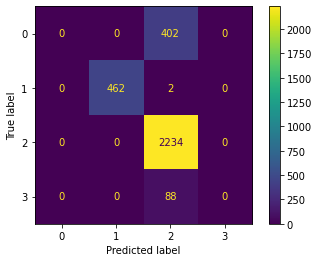

In [97]:
ConfusionMatrixDisplay.from_predictions(new_y_train, y_pred_train_b)
plt.show()

In [71]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test[-600:-550], y_test.iloc[-600:-550])[INDEX_ACCURACY]:.4f}')

2/2 [==============================] - 1s 406ms/step - loss: 11.2187 - accuracy: 0.3000

Accuracy on the test set: 0.3000


In [31]:
np.set_printoptions(suppress=True)

In [32]:
y_pred = model.predict(X_test)
y_pred

37/37 [==============================] - 21s 552ms/step


array([[0.24396832, 0.00132348, 0.65313464, 0.10157349],
       [0.24241799, 0.00090088, 0.66107225, 0.09560883],
       [0.23714446, 0.0020777 , 0.65617394, 0.10460388],
       ...,
       [0.0000006 , 0.9999986 , 0.00000073, 0.00000001],
       [0.00000006, 0.9999997 , 0.00000006, 0.        ],
       [0.00000028, 0.9999995 , 0.0000003 , 0.        ]], dtype=float32)

In [46]:
y_pred_b = [np.argmax(i, axis=0) for i in y_pred]

In [45]:
INDEX_PLAY = 2
print(f"Checking if the model always predicts 'play' (majority class): \n"
      f"{(np.argmax(y_pred, axis=1) == INDEX_PLAY).all()}")

Checking if the model always predicts 'play' (majority class): 
False


In [36]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [37]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

In [97]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

## Building 3rd baseline model - with negatives and undersampling

In [98]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True)

In [99]:
model = build_model(X_train)
model = compile_model(model)

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_5 (Batc  (None, 118, 158, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 78, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 20, 26, 256)     

In [102]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
85/85 [==============================] - 118s 1s/step - loss: 1.1787 - accuracy: 0.5669 - val_loss: 0.9698 - val_accuracy: 0.5396
Epoch 2/100
85/85 [==============================] - 117s 1s/step - loss: 0.7976 - accuracy: 0.6051 - val_loss: 0.7561 - val_accuracy: 0.6393
Epoch 3/100
85/85 [==============================] - 117s 1s/step - loss: 0.7192 - accuracy: 0.6235 - val_loss: 0.7234 - val_accuracy: 0.6276
Epoch 4/100
85/85 [==============================] - 117s 1s/step - loss: 0.6713 - accuracy: 0.6419 - val_loss: 0.6428 - val_accuracy: 0.6012
Epoch 5/100
85/85 [==============================] - 117s 1s/step - loss: 0.6723 - accuracy: 0.6419 - val_loss: 0.6534 - val_accuracy: 0.6452
Epoch 6/100
85/85 [==============================] - 112s 1s/step - loss: 0.6594 - accuracy: 0.6390 - val_loss: 0.6180 - val_accuracy: 0.6276
Epoch 7/100
85/85 [==============================] - 113s 1s/step - loss: 0.6585 - accuracy: 0.6551 - val_loss: 0.6326 - val_accuracy: 0.6070
Epoch 

In [109]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

37/37 [==============================] - 21s 561ms/step - loss: 4.8980 - accuracy: 0.5355

Accuracy on the test set: 0.5355


In [110]:
y_pred = model.predict(X_test)
y_pred

37/37 [==============================] - 22s 586ms/step


array([[0.44273853, 0.00241926, 0.45778066, 0.09706157],
       [0.43851388, 0.00215782, 0.46522954, 0.09409876],
       [0.4426998 , 0.00191462, 0.46170855, 0.09367706],
       ...,
       [0.00000127, 0.9999965 , 0.00000192, 0.00000028],
       [0.00000011, 0.9999997 , 0.00000016, 0.00000002],
       [0.00001513, 0.99995625, 0.00002477, 0.00000376]], dtype=float32)

In [111]:
INDEX_PLAY = 2
print(f"Checking if the model always predicts 'play' (majority class): \n"
      f"{(np.argmax(y_pred, axis=1) == INDEX_PLAY).all()}")

Checking if the model always predicts 'play' (majority class): 
False


43/43 [==============================] - 23s 540ms/step


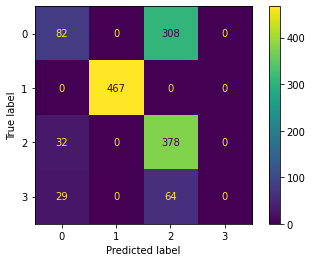

In [113]:
new_y_train = y_train.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

y_pred_train = model.predict(X_train)

y_pred_train_b = [np.argmax(i, axis=0) for i in y_pred_train]

ConfusionMatrixDisplay.from_predictions(new_y_train, y_pred_train_b)
plt.show()

In [112]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')

## Building 2nd baseline model - without negatives and without undersampling

In [114]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(negatives=False)

In [125]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [126]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_20 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_21 (Bat  (None, 20, 26, 256)     

In [127]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
171/171 [==============================] - 245s 1s/step - loss: 0.7901 - accuracy: 0.7772 - val_loss: 0.5993 - val_accuracy: 0.8211
Epoch 2/100
171/171 [==============================] - 229s 1s/step - loss: 0.6180 - accuracy: 0.8120 - val_loss: 0.5803 - val_accuracy: 0.8211
Epoch 3/100
171/171 [==============================] - 230s 1s/step - loss: 0.6191 - accuracy: 0.8117 - val_loss: 0.5602 - val_accuracy: 0.8211
Epoch 4/100
171/171 [==============================] - 237s 1s/step - loss: 0.5920 - accuracy: 0.8183 - val_loss: 0.5647 - val_accuracy: 0.8211
Epoch 5/100
171/171 [==============================] - 235s 1s/step - loss: 0.5746 - accuracy: 0.8179 - val_loss: 0.5643 - val_accuracy: 0.8211
Epoch 6/100
171/171 [==============================] - 230s 1s/step - loss: 0.5744 - accuracy: 0.8183 - val_loss: 0.5604 - val_accuracy: 0.8211


In [128]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

31/31 [==============================] - 17s 539ms/step - loss: 0.6449 - accuracy: 0.8166

Accuracy on the test set: 0.8166


In [129]:
y_test.value_counts()

event_challenge  event_play  event_throwin
0.0              1.0         0.0              797
1.0              0.0         0.0              119
0.0              0.0         1.0               60
dtype: int64

In [131]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_play': 1, 'event_throwin': 2})

In [132]:
y_pred_test = model.predict(X_test)

31/31 [==============================] - 17s 550ms/step


In [136]:
y_pred_test

array([[0.26093358, 0.69313025, 0.04593618],
       [0.26077488, 0.69341046, 0.04581472],
       [0.24840511, 0.71047175, 0.04112311],
       ...,
       [0.23234387, 0.72367144, 0.04398466],
       [0.25015563, 0.67972046, 0.07012384],
       [0.19188392, 0.7704469 , 0.03766916]], dtype=float32)

In [133]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

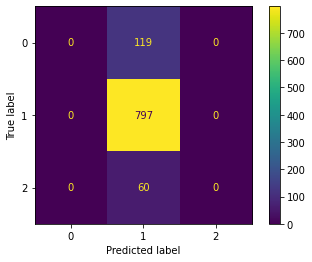

In [134]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [135]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_baseline_2')

## Building 3rd baseline model - without negatives and with undersampling

In [137]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(negatives=False, undersampling=True)

In [138]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((897, 480, 640, 3),
 (225, 480, 640, 3),
 (976, 480, 640, 3),
 (897, 3),
 (225, 3),
 (976, 3))

In [140]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [141]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_25 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_26 (Bat  (None, 20, 26, 256)     

In [142]:
model = train_model(model, X_train, y_train, X_val, y_val, patience=2)

Epoch 1/100
57/57 [==============================] - 77s 1s/step - loss: 1.6477 - accuracy: 0.4493 - val_loss: 0.9988 - val_accuracy: 0.4756
Epoch 2/100
57/57 [==============================] - 74s 1s/step - loss: 1.0638 - accuracy: 0.4615 - val_loss: 0.9628 - val_accuracy: 0.4711
Epoch 3/100
57/57 [==============================] - 82s 1s/step - loss: 1.0134 - accuracy: 0.4838 - val_loss: 0.9726 - val_accuracy: 0.4578
Epoch 4/100
57/57 [==============================] - 74s 1s/step - loss: 0.9931 - accuracy: 0.4504 - val_loss: 0.9841 - val_accuracy: 0.4489


In [143]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

31/31 [==============================] - 18s 582ms/step - loss: 0.8787 - accuracy: 0.7162

Accuracy on the test set: 0.7162


In [149]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_play': 1, 'event_throwin': 2})

In [150]:
y_pred_test = model.predict(X_test)

31/31 [==============================] - 17s 541ms/step


In [151]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

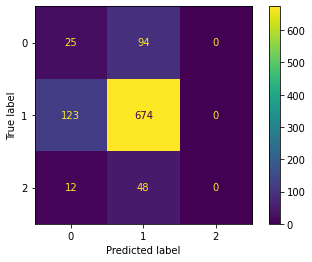

In [152]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [148]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_baseline_3')

## Building 5th baseline model - with gray, without negatives, and with undersampling

In [153]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(negatives=False, undersampling=True, gray=True)

In [154]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [155]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_30 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_31 (Bat  (None, 20, 26, 256)     

In [156]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
57/57 [==============================] - 82s 1s/step - loss: 1.5811 - accuracy: 0.4370 - val_loss: 1.0359 - val_accuracy: 0.4089
Epoch 2/100
57/57 [==============================] - 78s 1s/step - loss: 1.0736 - accuracy: 0.4426 - val_loss: 0.9612 - val_accuracy: 0.4044
Epoch 3/100
57/57 [==============================] - 76s 1s/step - loss: 1.0217 - accuracy: 0.4448 - val_loss: 0.9185 - val_accuracy: 0.5111
Epoch 4/100
57/57 [==============================] - 80s 1s/step - loss: 1.0050 - accuracy: 0.4214 - val_loss: 0.9270 - val_accuracy: 0.4756
Epoch 5/100
57/57 [==============================] - 75s 1s/step - loss: 0.9750 - accuracy: 0.4705 - val_loss: 0.9460 - val_accuracy: 0.4356
Epoch 6/100
57/57 [==============================] - 75s 1s/step - loss: 0.9784 - accuracy: 0.4849 - val_loss: 0.9162 - val_accuracy: 0.4800
Epoch 7/100
57/57 [==============================] - 75s 1s/step - loss: 0.9818 - accuracy: 0.4627 - val_loss: 0.9482 - val_accuracy: 0.4178
Epoch 8/100
5

In [157]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

31/31 [==============================] - 17s 536ms/step - loss: 1.0528 - accuracy: 0.1445

Accuracy on the test set: 0.1445


In [158]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_play': 1, 'event_throwin': 2})

In [159]:
y_pred_test = model.predict(X_test)

31/31 [==============================] - 17s 537ms/step


In [160]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

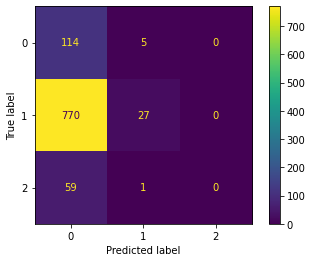

In [161]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [164]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_baseline_5')

## Building 4th baseline model - with gray, without negatives, and without undersampling

In [165]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(negatives=False, gray=True)

In [166]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [167]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_35 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_36 (Bat  (None, 20, 26, 256)     

In [168]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
171/171 [==============================] - 213s 1s/step - loss: 0.7735 - accuracy: 0.7849 - val_loss: 0.5908 - val_accuracy: 0.8211
Epoch 2/100
171/171 [==============================] - 219s 1s/step - loss: 0.6219 - accuracy: 0.8139 - val_loss: 0.5902 - val_accuracy: 0.8211
Epoch 3/100
171/171 [==============================] - 217s 1s/step - loss: 0.6027 - accuracy: 0.8183 - val_loss: 0.5593 - val_accuracy: 0.8211
Epoch 4/100
171/171 [==============================] - 221s 1s/step - loss: 0.5946 - accuracy: 0.8183 - val_loss: 0.5446 - val_accuracy: 0.8211
Epoch 5/100
171/171 [==============================] - 225s 1s/step - loss: 0.5742 - accuracy: 0.8183 - val_loss: 0.5564 - val_accuracy: 0.8211
Epoch 6/100
171/171 [==============================] - 216s 1s/step - loss: 0.5685 - accuracy: 0.8183 - val_loss: 0.5627 - val_accuracy: 0.8211
Epoch 7/100
171/171 [==============================] - 214s 1s/step - loss: 0.5699 - accuracy: 0.8179 - val_loss: 0.5983 - val_accuracy:

In [169]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

31/31 [==============================] - 17s 556ms/step - loss: 0.6335 - accuracy: 0.8166

Accuracy on the test set: 0.8166


In [170]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_play': 1, 'event_throwin': 2})

In [171]:
y_pred_test = model.predict(X_test)

31/31 [==============================] - 17s 541ms/step


In [175]:
y_pred_test

array([[0.15586776, 0.8135165 , 0.03061571],
       [0.15354751, 0.81639475, 0.03005778],
       [0.16790268, 0.7999405 , 0.03215671],
       ...,
       [0.21948591, 0.7063011 , 0.07421295],
       [0.22412258, 0.6849496 , 0.09092791],
       [0.21324569, 0.73492104, 0.05183332]], dtype=float32)

In [172]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

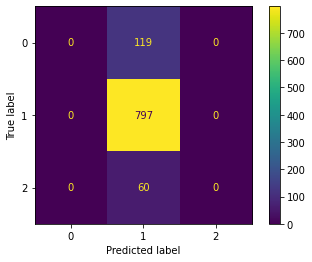

In [173]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [174]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_baseline_4')

## Building 6th baseline model - like 5th but CNN architecture more complex

In [177]:
def build_model(X_train, y_train):
  """ """
  input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]
  num_classes = y_train.shape[1]

  if MODEL == 'AlexNet':
    model = Sequential([
        Rescaling(1/255, 
                  input_shape=input_shape),  

        Conv2D(filters=96, 
               kernel_size=(11, 11), 
               strides=(4, 4), 
               activation='relu'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=256, 
               kernel_size=(5, 5),
               strides=(1, 1), # (3, 3)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(1, 1), # (2, 2)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(1, 1), # (2, 2)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=256, 
               kernel_size=(3, 3),
               strides=(1, 1), 
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Flatten(),

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(num_classes, 
              activation='softmax')
        ])

    return model

In [178]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(negatives=False, undersampling=True, gray=True)

In [179]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [180]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 480, 640, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization_40 (Bat  (None, 118, 158, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 58, 78, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 58, 78, 256)       614656    
                                                                 
 batch_normalization_41 (Bat  (None, 58, 78, 256)     

In [181]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
57/57 [==============================] - 302s 5s/step - loss: 11.8612 - accuracy: 0.4225 - val_loss: 141.1526 - val_accuracy: 0.5111
Epoch 2/100
57/57 [==============================] - 306s 5s/step - loss: 1.3551 - accuracy: 0.4247 - val_loss: 2.3697 - val_accuracy: 0.4400
Epoch 3/100
57/57 [==============================] - 299s 5s/step - loss: 1.0040 - accuracy: 0.4292 - val_loss: 1.2681 - val_accuracy: 0.4978
Epoch 4/100
57/57 [==============================] - 303s 5s/step - loss: 0.9695 - accuracy: 0.4370 - val_loss: 1.2092 - val_accuracy: 0.5111
Epoch 5/100
57/57 [==============================] - 298s 5s/step - loss: 0.9641 - accuracy: 0.4615 - val_loss: 1.1250 - val_accuracy: 0.4533
Epoch 6/100
57/57 [==============================] - 297s 5s/step - loss: 0.9553 - accuracy: 0.4426 - val_loss: 1.0192 - val_accuracy: 0.3822
Epoch 7/100
57/57 [==============================] - 299s 5s/step - loss: 0.9569 - accuracy: 0.4470 - val_loss: 0.9823 - val_accuracy: 0.4178
Epo

In [182]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

31/31 [==============================] - 84s 3s/step - loss: 0.8605 - accuracy: 0.7766

Accuracy on the test set: 0.7766


In [183]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_play': 1, 'event_throwin': 2})

In [184]:
y_pred_test = model.predict(X_test)

31/31 [==============================] - 86s 3s/step


In [185]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

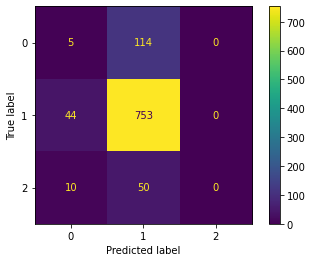

In [186]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [187]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_baseline_6')